In [1]:
#import block
import tensorflow as tf
import h5py
import numpy as np
import json
import pandas as pd
import math
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

2021-11-16 04:40:18.038003: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-16 04:40:18.038027: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#Function block for grabbing a section of the data
def grabData(start=0, stop=0, step=8):
  if(stop == 0):
    samples = hdf5_file['X'][start::step]
    modulation_classes = hdf5_file['Y'][start::step]
    snr = hdf5_file['Z'][start::step]
  else:
    samples = hdf5_file['X'][start:stop:step]
    modulation_classes = hdf5_file['Y'][start:stop:step]
    snr = hdf5_file['Z'][start:stop:step]

  mod_array = np.zeros(len(modulation_classes))
  i = 0
  for x in modulation_classes:
    mod_array[i] = np.where(x==1)[0][0]
    i = i + 1

  return samples, mod_array, snr

In [3]:
#function block for shuffling dataset
def shuffleDataset(samp, mod, snr):
  samp, mod, snr = shuffle(samp, mod, snr, random_state=0)
  return samp, mod, snr

In [4]:
#function block for splitting dataset into training, validation, and testing
#creates tf.Dataset objects
def datasetSplit(samples, mod, snr, training_index=.8, validation_index=.1):
  trn_ind = math.floor(len(mod) * training_index)
  val_ind = math.floor(len(mod) * validation_index)

  training_set, training_label, training_snr = samples[:trn_ind:], mod[:trn_ind:], snr[:trn_ind:]
  validation_set, validation_label, validation_snr = samples[trn_ind:trn_ind+val_ind:], mod[trn_ind:trn_ind+val_ind:], snr[trn_ind:trn_ind+val_ind:]
  test_set, test_label, test_snr = samples[trn_ind+val_ind::], mod[trn_ind+val_ind::], snr[trn_ind+val_ind::]

  tr_dataset = tf.data.Dataset.from_tensor_slices((training_set, training_label))
  val_dataset = tf.data.Dataset.from_tensor_slices((validation_set, validation_label))
  test_dataset = tf.data.Dataset.from_tensor_slices((test_set, test_label))

  print(test_dataset.)
  return tr_dataset, val_dataset, test_dataset

In [5]:
#function for performing changes to the tf.Dataset objects like batching, shuffling, etc.
def datasetManip(dset, batch_s=100, buf_s=1000, drop_rem=True):
  dset_trans = dset.shuffle(buffer_size=buf_size).batch(batch_s, drop_remainder=drop_rem)
  return dset_trans

In [6]:
#function block for compiling and fitting model
#returns the history callback of the trained model
def trainModel(model, loss_func, trn, val, optim='Adam', num_epochs=10):
  model.compile(optimizer=optim, loss=loss_func, metrics=['accuracy'])
  model.summary()
  model_history = model.fit(trn, epochs=num_epochs, validation_data=val, verbose=1)
  return model_history

In [7]:
#function block to plot a model's loss and accuracy through its history
def plotHistory(hist, plot_title):
  #summarize history for accuracy
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  
  full_title = plot_title + " accuracy"
  plt.title(full_title)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  
  plt.show()
  #summarize history for loss
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  
  full_title = plot_title + " loss"
  plt.title(full_title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  
  plt.show()

In [8]:
#function block for using model for predictions

In [9]:
#Main block for calling functions
##code block for loading in DeepSig data from hdf5 file

# Open the dataset
# hdf5_file = h5py.File("/content/content/DeepSig_shuffled/DeepSig_XYZ_OSC.0001_1024_Shuffled.hdf5",  'r')
hdf5_file = h5py.File("../dataset/DeepSig_XYZ_OSC.0001_1024_Shuffled.hdf5",  'r')

# Load the modulation classes. You can also copy and paste the content of classes-fixed.txt.
# modulation_classes = json.load(open("/content/content/DeepSig_shuffled/classes-fixed.json", 'r'))
modulation_classes = json.load(open("../dataset/classes-fixed.json", 'r'))

#List groups of the hdf5 file
list(hdf5_file.keys())
#DeepSig image input shape
img_width, img_height, img_channels = (1024, 2, 1)

In [10]:
#block for writing out models to be tested

#write out models to be tested
five_layers = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(64, 3, activation='relu', 
                  input_shape=(img_width, img_height)),
      tf.keras.layers.MaxPooling1D(2, 2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation=tf.nn.selu),
      tf.keras.layers.Dense(128, activation=tf.nn.selu),
      tf.keras.layers.Dense(24, activation=tf.nn.softmax)
    ])

six_layers = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(64, 3, activation='relu', 
                  input_shape=(img_width, img_height)),
      tf.keras.layers.MaxPooling1D(2, 2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation=tf.nn.selu),
      tf.keras.layers.Dense(128, activation=tf.nn.selu),
      tf.keras.layers.Dense(24, activation=tf.nn.softmax)
    ])

seven_layers = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(64, 3, activation='relu', 
                  input_shape=(img_width, img_height)),
      tf.keras.layers.MaxPooling1D(2, 2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation=tf.nn.selu),
      tf.keras.layers.Dense(128, activation=tf.nn.selu),
      tf.keras.layers.Dense(24, activation=tf.nn.softmax)
    ])

eight_layers = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(64, 3, activation='relu', 
                  input_shape=(img_width, img_height)),
      tf.keras.layers.MaxPooling1D(2, 2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Conv1D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation=tf.nn.selu),
      tf.keras.layers.Dense(128, activation=tf.nn.selu),
      tf.keras.layers.Dense(24, activation=tf.nn.softmax)
    ])

#put the model objects in here
model_list = [five_layers, six_layers, seven_layers, eight_layers]

#put the model names in here
model_names = ["five_layers", "six_layers", "seven_layers", "eight_layers"]

2021-11-16 04:40:19.090543: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-16 04:40:19.090563: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-16 04:40:19.090574: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bolt): /proc/driver/nvidia/version does not exist
2021-11-16 04:40:19.090786: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
#Grabbing data and creating datasets

#variable block
start = 0
stop = 0
fraction = 8 #takes 1/fraction of the original dataset
train_split = .8
val_split = .1
buf_size = 10000
batch_size = 1000
drop_rem = True

#dataset split creation block
samples, mod, snr = grabData(start, stop, fraction)
samples, mod, snr = shuffleDataset(samples, mod, snr)
train_ds, val_ds, test_ds = datasetSplit(samples, mod, snr, train_split, val_split)
train_ds = datasetManip(train_ds, batch_size, buf_size, drop_rem)
val_ds = datasetManip(val_ds, batch_size, buf_size, drop_rem)
test_ds = datasetManip(test_ds, batch_size, buf_size, drop_rem)

2021-11-16 04:40:43.549002: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2093793280 exceeds 10% of free system memory.
2021-11-16 04:40:44.102840: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 261718016 exceeds 10% of free system memory.
2021-11-16 04:40:44.173205: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 261734400 exceeds 10% of free system memory.


2021-11-16 04:40:44.266212: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2093793280 exceeds 10% of free system memory.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1022, 64)          448       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 511, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 509, 64)           12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 254, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 252, 64)           12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 126, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 124, 64)           1

2021-11-16 04:40:45.276027: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2093793280 exceeds 10% of free system memory.


Epoch 1/10


2021-11-16 04:40:46.633719: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


255/255 [==============================] - 183s 714ms/step - loss: 1.7508 - accuracy: 0.3663 - val_loss: 1.4150 - val_accuracy: 0.4497
Epoch 2/10
255/255 [==============================] - 184s 723ms/step - loss: 1.3602 - accuracy: 0.4811 - val_loss: 1.3097 - val_accuracy: 0.5040
Epoch 3/10
255/255 [==============================] - 183s 717ms/step - loss: 1.2941 - accuracy: 0.5098 - val_loss: 1.2814 - val_accuracy: 0.5109
Epoch 4/10
255/255 [==============================] - 183s 718ms/step - loss: 1.2588 - accuracy: 0.5256 - val_loss: 1.2505 - val_accuracy: 0.5243
Epoch 5/10
255/255 [==============================] - 183s 719ms/step - loss: 1.2335 - accuracy: 0.5359 - val_loss: 1.2362 - val_accuracy: 0.5294
Epoch 6/10
255/255 [==============================] - 185s 724ms/step - loss: 1.2149 - accuracy: 0.5433 - val_loss: 1.2303 - val_accuracy: 0.5308
Epoch 7/10
255/255 [==============================] - 184s 722ms/step - loss: 1.2011 - accuracy: 0.5489 - val_loss: 1.2384 - val_accura

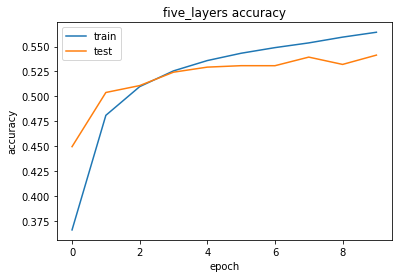

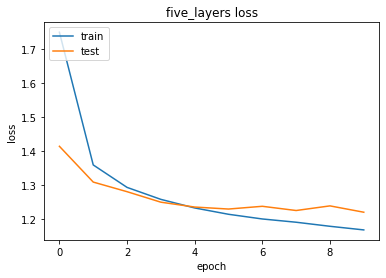

2021-11-16 05:11:33.244779: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/five_layers/assets
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 1022, 64)          448       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 511, 64)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 509, 64)           12352     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 254, 64)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 252, 64)           12352     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 126, 64)           0         
_________________________________________________________

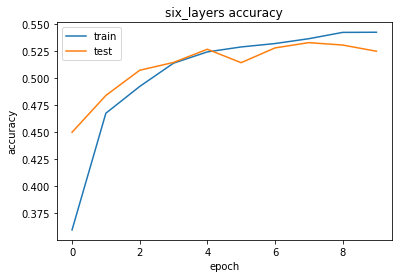

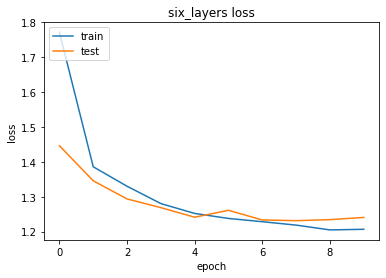

INFO:tensorflow:Assets written to: ./models/six_layers/assets
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 1022, 64)          448       
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 511, 64)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 509, 64)           12352     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 254, 64)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 252, 64)           12352     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 126, 64)           0         
__________________________________________________________

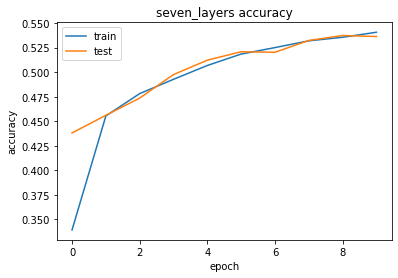

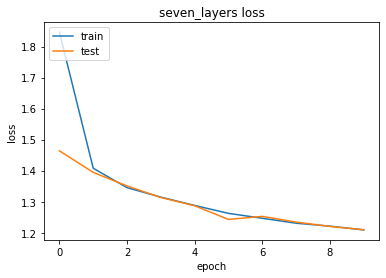

INFO:tensorflow:Assets written to: ./models/seven_layers/assets
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 1022, 64)          448       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 511, 64)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 509, 64)           12352     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 254, 64)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 252, 64)           12352     
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 126, 64)           0         
________________________________________________________

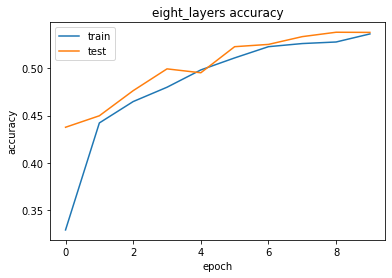

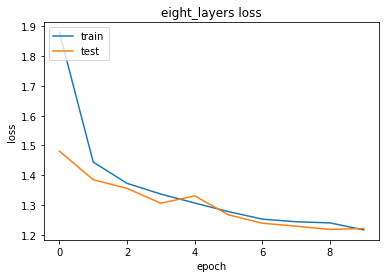

INFO:tensorflow:Assets written to: ./models/eight_layers/assets


In [12]:
#Setting model variables, compiling/training models, and graphing metrics

#variable block
optimizer = 'Adam'
loss_function = 'sparse_categorical_crossentropy'
number_of_epochs = 10

model_histories = []
ind = 0;
for x in model_list:
  current_history = trainModel(x, loss_function, train_ds, val_ds, optimizer, number_of_epochs)
  model_histories.append(current_history)
  plotHistory(current_history, model_names[ind])
  x.save(f'./models/{model_names[ind]}')
  ind = ind + 1

In [13]:
! unzip /content/drive/MyDrive/DS_shuffled.zip -d /content/

unzip:  cannot find or open /content/drive/MyDrive/DS_shuffled.zip, /content/drive/MyDrive/DS_shuffled.zip.zip or /content/drive/MyDrive/DS_shuffled.zip.ZIP.
